In [ ]:
import numpy as np
from gal_goku import hmf as halo_mass_func

for fid in ['HF', 'L2', 'L1']:
    base_dir = f'/scratch/06536/qezlou/Goku/FOF/{fid}'
    save_File = f'/scratch/06536/qezlou/Goku/processed_data/HMF/{fid}_hmfs.hdf5'
    hmf = halo_mass_func.Hmf()
    hmf.get_all_fof_hmfs(base_dir=base_dir, save_file=save_File)
    print(f'fid = {fid} is done!')

2025-01-09 15:08:18.536618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 15:08:18.629503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 15:08:18.629525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 15:08:18.655955: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 15:08:19.098727: W tensorflow/stream_executor/platform/de

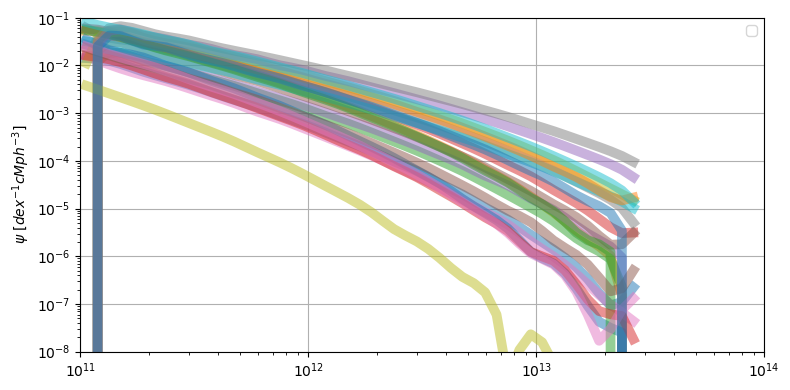

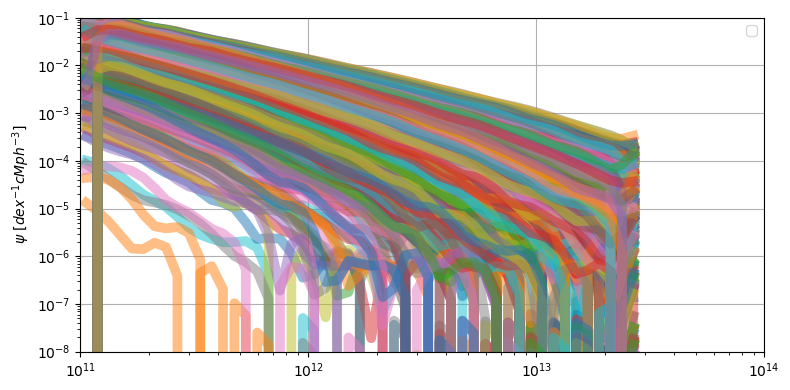

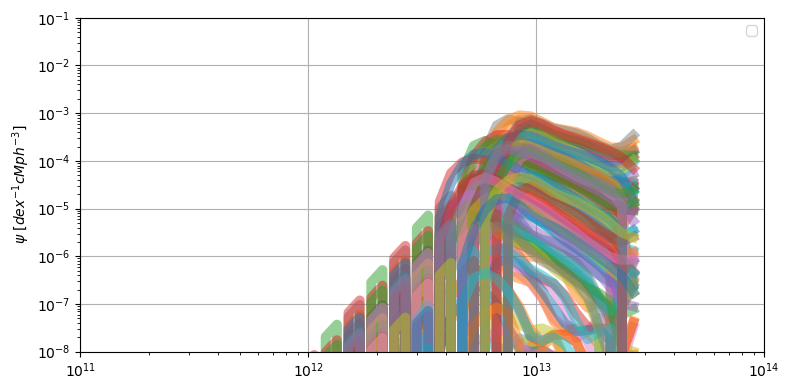

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.sim_hmf(fids=['HF'])
plt_hmf.sim_hmf(fids=['L2'])
plt_hmf.sim_hmf(fids=['L1'])

2025-01-09 15:46:22.034922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 15:46:22.127160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 15:46:22.127180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 15:46:22.153706: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 15:46:22.596305: W tensorflow/stream_executor/platform/de

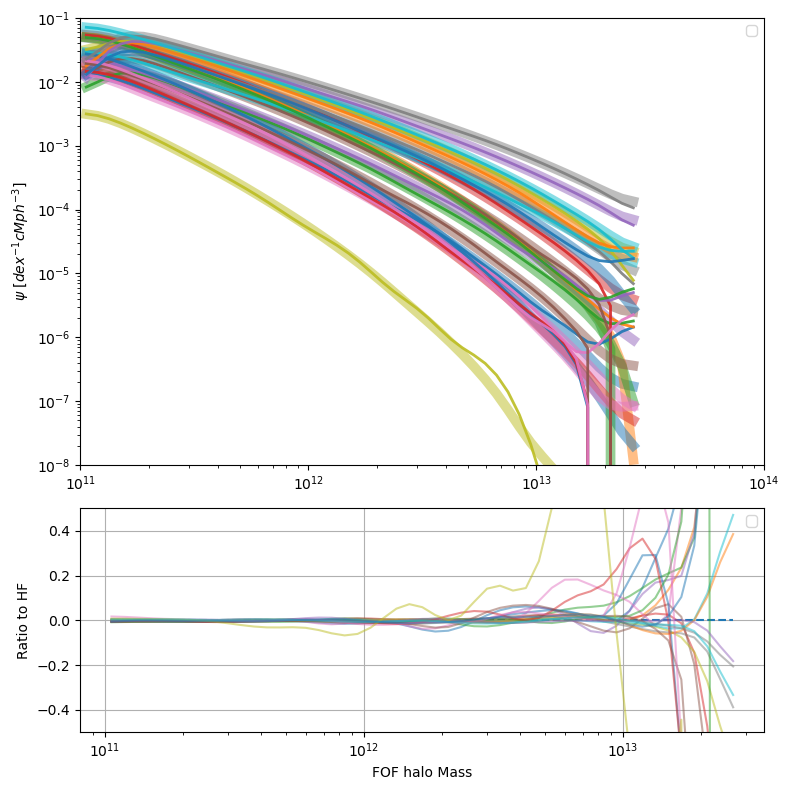

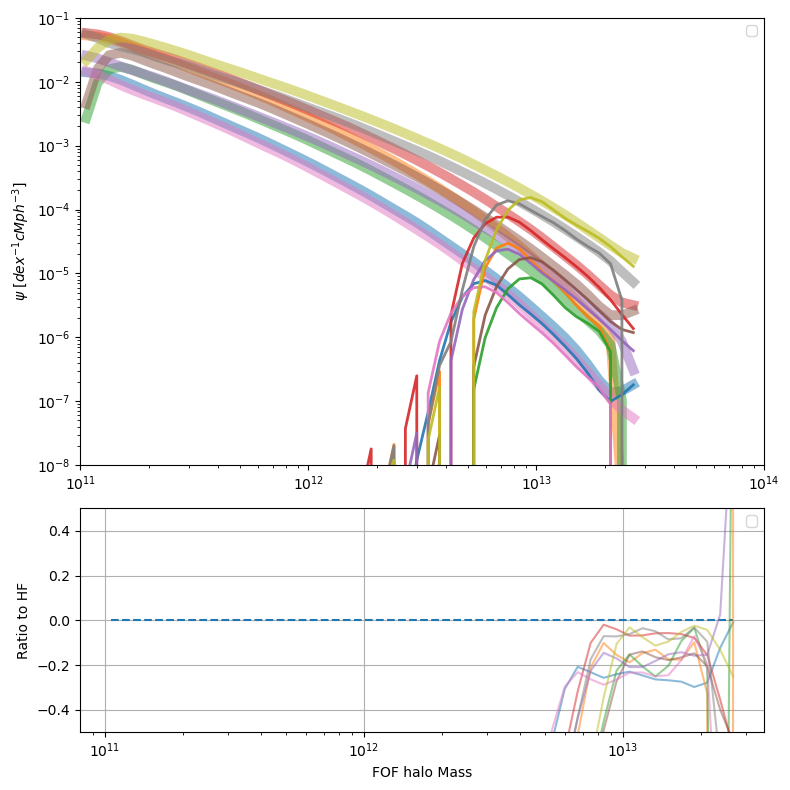

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.compare_fids(fids=['HF', 'L2'], sigma=2)
plt_hmf.compare_fids(fids=['HF', 'L1'], sigma=1)

2025-01-09 16:52:29.025156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 16:52:29.117351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 16:52:29.117373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 16:52:29.143701: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 16:52:29.587868: W tensorflow/stream_executor/platform/de

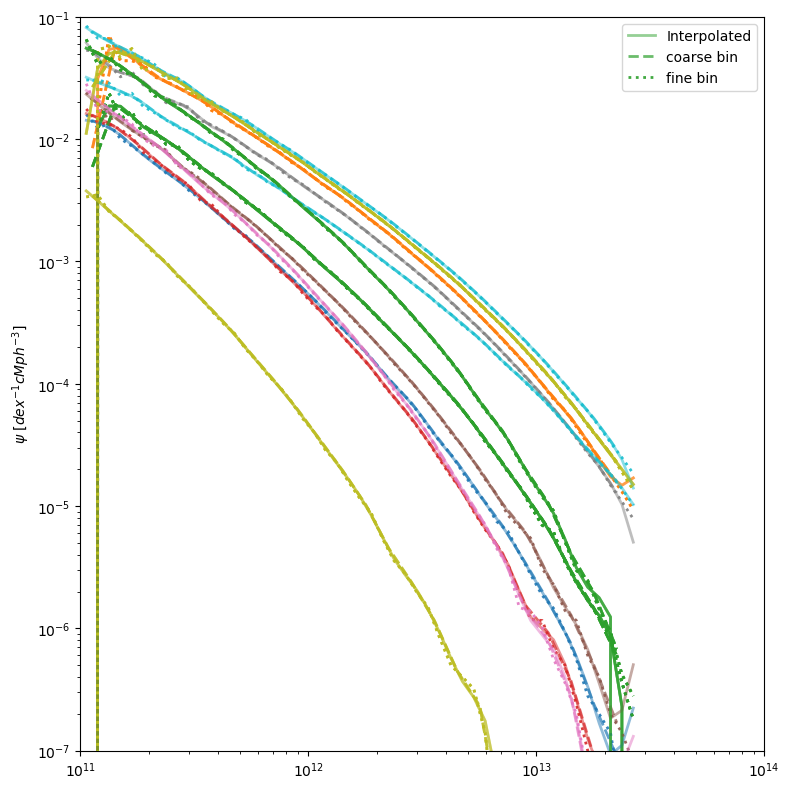

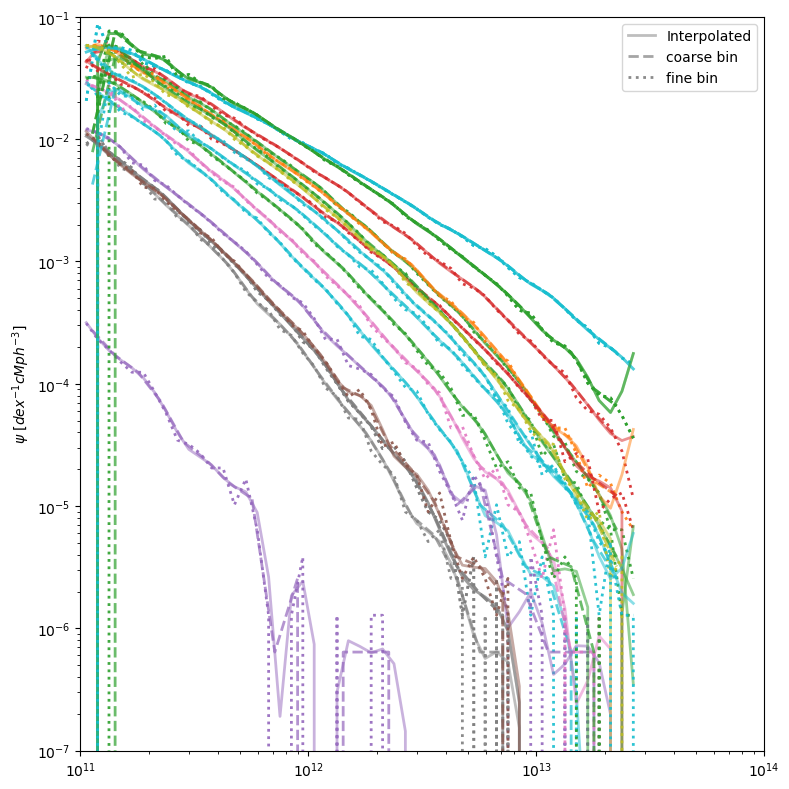

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.check_smoothed_hmf(fids=['HF','L2'])

# HMF Emu:

## Single fid on L2: